In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from skimage.transform import resize

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
ids_test = load_array("data/array/ids_test")
X_test = load_array("data/array/X_test")

In [4]:
model = load_model('models/unet-dropout.model', custom_objects={'mean_iou': mean_iou})

In [5]:
pred_test = model.predict(X_test, verbose=1)

18000/18000 [==============================] - 32s 2ms/step


## Sanity check

In [6]:
threshold = 0.7

In [7]:
pred_test_tresh = np.int32(pred_test > threshold)

In [8]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as image_utils

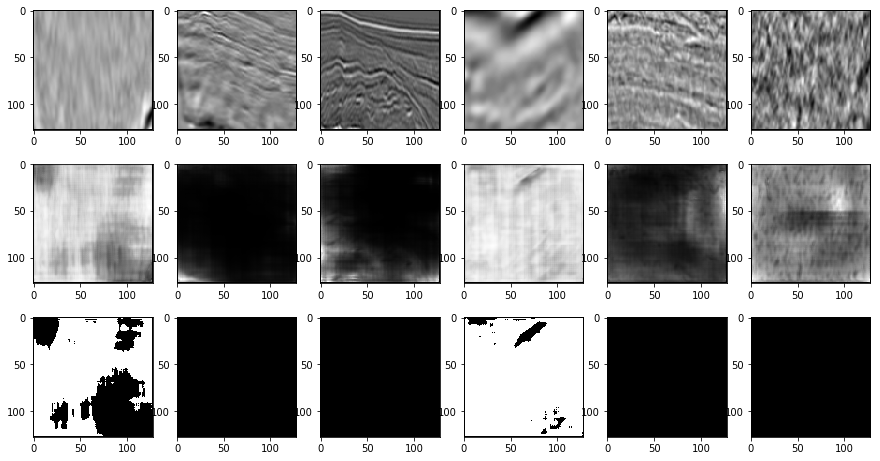

In [9]:
n_images = 6
fig, axarr = plt.subplots(3, n_images, figsize=(15, 8))
for image in range(n_images):
    n = random.randint(1, X_test.shape[0])
    axarr[0, image].imshow(image_utils.array_to_img(X_test[n]))
    axarr[1, image].imshow(image_utils.array_to_img(pred_test[n]))
    axarr[2, image].imshow(image_utils.array_to_img(pred_test_tresh[n]))

## Create submission

Here we downsample first and then do the treshold mask again

In [10]:
import pandas as pd

In [11]:
preds_test_downsample = []
for i in tqdm.tnrange(len(pred_test)):
    # Resize it back to original size: 101x101
    preds_test_downsample.append(np.int32(downsample(pred_test[i]) > threshold))

In [12]:
pred_dict = {img_id: rle_encode(preds_test_downsample[i]) for i, img_id in tqdm.tqdm_notebook(enumerate(ids_test), total=len(ids_test))}

In [13]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

In [14]:
sub.head()

,rle_mask
id,
0005bb9630,NaN
000a68e46c,NaN
000c8dfb2a,106 96 210 93 324 80 425 59 485 20 529 50 580 ...
000d0a5f6c,103 72 204 73 305 23 331 46 406 24 431 44 507 ...
001ef8fc87,103 99 204 99 305 99 406 99 507 99 608 99 709 ...


In [15]:
sub.to_csv('submission.csv')

In [16]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f submission.csv -m "Unet with dropout threshold=0.7"

Successfully submitted to TGS Salt Identification Challenge